In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from loader import load_data
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [3]:
df = load_data(r"/Users/christian/supsi/6th sem/bayesian_retry/data_hockey")
df = df.loc[df.Resultat != " -:-"].reset_index(drop=True)
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Do,29.04.2021,20:00,ZSC Lions,Genève-Servette HC,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",50,"SRF,RTS,RSI,MYSPORTS",20211105000354,NL,CH,Playoff 1/2 Final
2446,Sa,01.05.2021,20:00,SC Rapperswil-Jona Lakers,EV Zug,3:6,0:3|2:1|1:2,NaN,Ende,False,"St.Galler Kantonalbank Arena, 8640 Rapperswil SG",50,"SRF,RTS,RSI,MYSPORTS",20211105000355,NL,CH,Playoff 1/2 Final
2447,Mo,03.05.2021,20:00,EV Zug,Genève-Servette HC,1:0,0:0|1:0|0:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",50,"SRF,RTS,RSI,MYSPORTS",20211105000359,NL,CH,Playoff Final
2448,Mi,05.05.2021,19:00,Genève-Servette HC,EV Zug,1:2,0:0|1:1|0:1,NaN,Ende,False,"Les Vernets, 1227 Les Acacias GE",50,"SRF,RTS,RSI,MYSPORTS",20211105000360,NL,CH,Playoff Final


# Preprocessing

In [4]:
# Split the Resultat into home and away goals
df['Home_goals'] = df['Resultat'].str.split(':').str[0].astype(int)
df['Away_goals'] = df['Resultat'].str.split(':').str[1].astype(int)

# Create a new dataframe in the Spotify format
home_df = df[['Home', 'Away', 'Home_goals']]
away_df = df[['Away', 'Home', 'Away_goals']]

hockey_df = pd.concat([home_df, away_df]).sort_values(by="Home").reset_index(drop=True).fillna(0)
hockey_df

,Home,Away,Home_goals,Away_goals
0,EHC Biel-Bienne,EV Zug,1.0,0.0
1,EHC Biel-Bienne,Fribourg-Gottéron,0.0,3.0
2,EHC Biel-Bienne,HC Ambri-Piotta,3.0,0.0
3,EHC Biel-Bienne,HC Ambri-Piotta,0.0,2.0
4,EHC Biel-Bienne,Genève-Servette HC,0.0,4.0
...,...,...,...,...
4895,ZSC Lions,Fribourg-Gottéron,6.0,0.0
4896,ZSC Lions,HC Lugano,0.0,1.0
4897,ZSC Lions,SCL Tigers,2.0,0.0
4898,ZSC Lions,EHC Kloten,0.0,2.0


In [5]:
# Scores for 'HC Lugano' when they played at home
hcl_home_scores = hockey_df[hockey_df['Home'] == 'HC Lugano']['Home_goals'].tolist()

# Scores for 'HC Lugano' when they played away
hcl_away_scores = hockey_df[hockey_df['Away'] == 'HC Lugano']['Away_goals'].tolist()



hockey_df['home_team_code'] = hockey_df['Home'].astype('category').cat.codes

print(hcl_home_scores)
print(hcl_away_scores)

[2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 5.0, 4.0, 1.0, 0.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 0.0, 2.0, 2.0, 0.0, 1.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 1.0, 6.0, 0.0, 4.0, 0.0, 5.0, 7.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 8.0, 2.0, 0.0, 0.0, 2.0, 6.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 4.0, 0.0, 0.0, 3.0, 0.0, 4.0, 0.0, 4.0, 5.0, 0.0, 6.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 3.0, 4.0, 0.0, 0.0, 5.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 3.0, 0.0, 0.0, 3.0, 3.0, 4.0, 0.0, 3.0, 1.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 4.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 6.0, 0.0, 0.0, 0.0, 3.0, 3.0, 4.0, 0.0, 0.0, 0.0, 6.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 5.0, 0.0, 2.0, 3.0, 3.0, 2.0, 0.0, 3.0, 4.0, 0.0,

In [6]:
# Create two versions of the dataframe: one for home teams, another for away teams
home_df = hockey_df[['Home', 'Home_goals']].rename(columns={'Home':'Team', 'Home_goals':'Goals'})
away_df = hockey_df[['Away', 'Away_goals']].rename(columns={'Away':'Team', 'Away_goals':'Goals'})

# Concatenate these two dataframes
flattened_df = pd.concat([home_df, away_df], axis=0).reset_index(drop=True)

# Assign a numerical code to each team
flattened_df['team_code'] = flattened_df['Team'].astype('category').cat.codes

In [7]:
hockey_df

,Home,Away,Home_goals,Away_goals,home_team_code
0,EHC Biel-Bienne,EV Zug,1.0,0.0,0
1,EHC Biel-Bienne,Fribourg-Gottéron,0.0,3.0,0
2,EHC Biel-Bienne,HC Ambri-Piotta,3.0,0.0,0
3,EHC Biel-Bienne,HC Ambri-Piotta,0.0,2.0,0
4,EHC Biel-Bienne,Genève-Servette HC,0.0,4.0,0
...,...,...,...,...,...
4895,ZSC Lions,Fribourg-Gottéron,6.0,0.0,14
4896,ZSC Lions,HC Lugano,0.0,1.0,14
4897,ZSC Lions,SCL Tigers,2.0,0.0,14
4898,ZSC Lions,EHC Kloten,0.0,2.0,14


# Pooled model

# Research question
From the distributions we see that when the game is played at home the mean goals are higher.

We want to test if this is true:
* Are the expected goals for the home team higher than the ones away?

We assume the distribution is Normal.

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_{home}$, $\bar{y}_{away}$) 

    * sample standard deviations ($s_{home}, s_{away}$) 

    * numerosity ($n_{home}, n_{away}$)


* The sample are drawn from two populations with unknown parameters $\mu_{home}, \mu_{away}, \sigma_{home}, \sigma_{away}$.

# Background information to set the prior
From a research we found the mean goals per game is 7.2. Given this we can divide the score between the two teams, resulting in a mean of 3.6 goals per team in one game.

Extreme values of goals are 0 and 8. A plausible value of standard deviation in the population is thus   (3.6 - 0)/2 = 1.8.

We know that:
$$
\frac{alpha}{beta} = mu
$$
$$
\frac{alpha}{beta^2} = sigma^2
$$

therefore we can calculate alpha and beta as:
$$
alpha = \frac{mu^2}{sigma^2}
$$
$$
beta = \frac{mu}{sigma^2}
$$

In [8]:
mu = 3.6
sigma = 1.8

alpha = mu**2 / sigma**2
beta = mu / sigma**2
alpha, beta

(4.0, 1.1111111111111112)

# Prior for $\mu_{\text{home}}$ and $\mu_{\text{away}}$

* The  mean goals of the population lies in (1.8, 5.4);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{home}}   \sim  Gam(4, 1.1)
$$
$$
\mu_{\text{away}}   \sim  Gam(4, 1.1)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



# Pooled model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).
$$
\mu \sim Gam(4,1.1) 
$$
$$
\vec{y} \sim Po(\mu)
$$


In [9]:
with pm.Model() as pooled_model:
    mu = pm.Gamma('mu', alpha, beta)
    y = pm.Poisson('y', mu=mu, observed=flattened_df["Goals"])
    
    trace_pooled = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


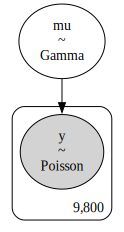

In [10]:
pm.model_to_graphviz(pooled_model)

In [11]:
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.417,0.012,1.395,1.44,0.0,0.0,1724.0,2758.0,1.0


array([[<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>]], dtype=object)

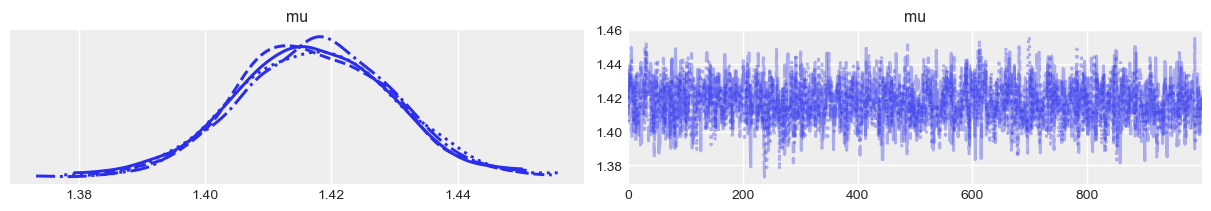

In [12]:
az.plot_trace(trace_pooled)

It converges well

### predictive distribution

In [13]:
#prediction distribution of the  pooled model
post_pooled = az.extract_dataset(trace_pooled.posterior)

#posterior samples
mu = post_pooled.mu.values

y_new = np.zeros(len(mu))
for i, current_mu in enumerate(mu):
        y_new[i] = np.random.poisson(lam=mu[i])

print('summary of predictive distribution: \n')
print(pd.DataFrame(y_new).describe(percentiles=[0.025, 0.975]))

summary of predictive distribution: 

                 0
count  4000.000000
mean      1.422000
std       1.214201
min       0.000000
2.5%      0.000000
50%       1.000000
97.5%     4.000000
max       9.000000


/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_203/2801434271.py:2: FutureWarning: extract_dataset has been deprecated, please use extract
  post_pooled = az.extract_dataset(trace_pooled.posterior)


In [14]:
with pm.Model() as pooled_model_with_preds:
    mu = pm.Gamma('mu', alpha, beta)
    y = pm.Poisson('y', mu=mu, observed=flattened_df["Goals"])

    # prediction, computed for every posterior sample of global_mean and global_sigma.
    predictive =  pm.Poisson('predictive', mu=mu)
    trace_pooled_with_preds = pm.sample(return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu]
>Metropolis: [predictive]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
az.summary(trace_pooled_with_preds, var_names='predictive')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive,1.495,1.212,0.0,4.0,0.047,0.033,691.0,801.0,1.01


array([[<AxesSubplot: title={'center': 'predictive'}>,
        <AxesSubplot: title={'center': 'predictive'}>],
       [<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>]], dtype=object)

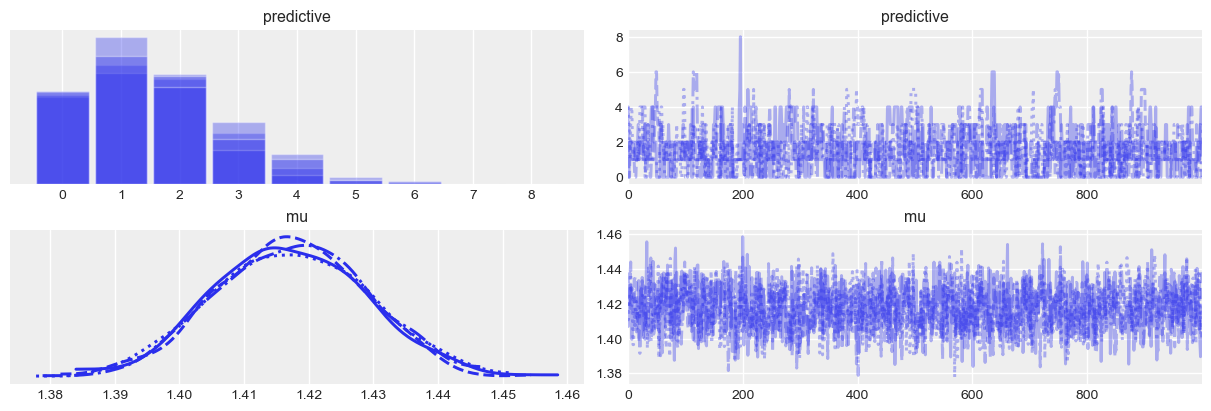

In [16]:
az.plot_trace(trace_pooled_with_preds)

# Unpooled model

In [17]:
n_teams = hockey_df['Home'].nunique() 
teams = hockey_df['Home'].unique()

hcl_code = np.unique(hockey_df['home_team_code'][hockey_df['Home']=='HC Lugano']).item()
hcap_code = np.unique(hockey_df['home_team_code'][hockey_df['Home']=='HC Ambri-Piotta']).item()

print('games from HCL: ', np.sum(hockey_df['Home'] == 'HC Lugano'))
print('games from HCAP: ', np.sum(hockey_df['Home'] == 'HC Ambri-Piotta'))

games from HCL:  416
games from HCAP:  392


In [18]:
teams

array(['EHC Biel-Bienne', 'EHC Kloten', 'EV Zug', 'Fribourg-Gottéron',
       'Genève-Servette HC', 'HC Ajoie', 'HC Ambri-Piotta', 'HC Davos',
       'HC Lugano', 'Lausanne HC', 'SC Bern', 'SC Langenthal',
       'SC Rapperswil-Jona Lakers', 'SCL Tigers', 'ZSC Lions'],
      dtype=object)

In [19]:
with pm.Model() as unpooled_model:
    # Priors
    mu_teams = pm.Gamma('mu_teams', alpha, beta, shape=n_teams)
    # Likelihood
    y = pm.Poisson('y', mu=mu_teams[flattened_df['team_code'].values], observed=flattened_df['Goals'])
    # Sampling
    trace_unpooled = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_teams]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


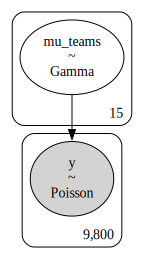

In [20]:
pm.model_to_graphviz(unpooled_model)

In [21]:
posterior = trace_unpooled.posterior.assign_coords(mu_teams_dim_0=teams)
az.summary(posterior).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_teams[EHC Biel-Bienne],1.441,0.042,1.364,1.521,0.001,0.000,4970.0,2984.0,1.0
mu_teams[EHC Kloten],1.331,0.060,1.222,1.446,0.001,0.001,4659.0,3062.0,1.0
mu_teams[EV Zug],1.607,0.043,1.527,1.684,0.001,0.000,5144.0,2997.0,1.0
mu_teams[Fribourg-Gottéron],1.381,0.042,1.304,1.462,0.001,0.000,5336.0,3195.0,1.0
mu_teams[Genève-Servette HC],1.433,0.042,1.357,1.512,0.001,0.000,6049.0,3264.0,1.0


[Text(0, 0.0, 'Genève-Servette HC'),
 Text(0, 0.825, 'Fribourg-Gottéron'),
 Text(0, 1.65, 'EV Zug'),
 Text(0, 2.4749999999999996, 'EHC Kloten'),
 Text(0, 3.3, 'EHC Biel-Bienne')]

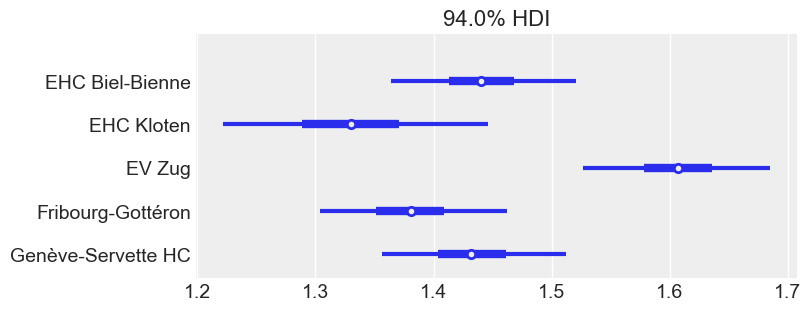

In [22]:
import arviz as az

# Convert PyMC3 trace to an arviz InferenceData object (if it's not already)
if not isinstance(trace_unpooled, az.InferenceData):
    trace_unpooled = az.from_pymc3(trace_unpooled)


# Plot the forest plot for the first 5 teams only
axes = az.plot_forest(trace_unpooled, 
               var_names=["mu_teams"], 
               combined=True, 
               coords={"mu_teams_dim_0": range(5)},  # Only the first 5 teams
               figsize=(8, 3))

axes[0].set_yticklabels(teams[:5][::-1])

### predictive

In [23]:
with pm.Model() as unpooled_model_with_preds:
    # Priors
    mu_teams = pm.Gamma('mu_teams', alpha, beta, shape=n_teams)
    # Likelihood
    y = pm.Poisson('y', mu=mu_teams[flattened_df['team_code'].values], observed=flattened_df['Goals'])
    
    predictive_hcl = pm.Poisson('predictive_hcl', mu=mu_teams[hcl_code])
    # Sampling
    trace_unpooled_with_preds = pm.sample(return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_teams]
>Metropolis: [predictive_hcl]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [24]:
az.summary(trace_unpooled_with_preds, var_names=['predictive_hcl'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive_hcl,1.523,1.212,0.0,4.0,0.046,0.035,736.0,629.0,1.0


array([[<AxesSubplot: title={'center': 'predictive_hcl'}>,
        <AxesSubplot: title={'center': 'predictive_hcl'}>],
       [<AxesSubplot: title={'center': 'mu_teams'}>,
        <AxesSubplot: title={'center': 'mu_teams'}>]], dtype=object)

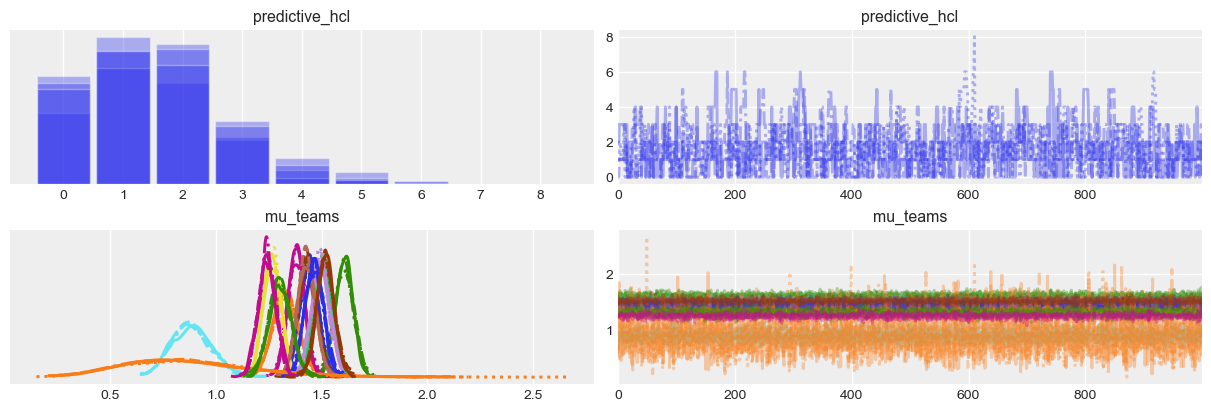

In [25]:
az.plot_trace(trace_unpooled_with_preds)

# Hierarchical

In [26]:
with pm.Model() as hierarchical_model:
    
    # Priors for global model parameters
    mu_global = pm.Gamma('mu_global', alpha, beta)
    
    # Hierarchical beta to control spread of team means around the global mean
    beta_global = pm.HalfCauchy('beta_global', beta=1)
    
    # Individual team means, informed by mu_global and beta_global
    mu_teams = pm.Gamma('mu_teams', alpha=mu_global, beta=beta_global, shape=n_teams)
    
    # Likelihood for each team's goals
    goals = pm.Poisson('goals', mu=mu_teams[flattened_df['team_code'].values], observed=flattened_df['Goals'])
    
    trace_hierarchical = pm.sample(1000, tune=1000, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_teams, beta_global, mu_global]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


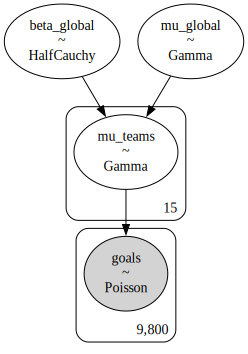

In [27]:
pm.model_to_graphviz(hierarchical_model)

In [28]:
az.summary(trace_hierarchical)[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_global,7.323,3.666,11.924,1.0
beta_global,5.426,2.440,8.875,1.0
mu_teams[0],1.439,1.361,1.520,1.0
mu_teams[1],1.324,1.214,1.432,1.0
mu_teams[2],1.604,1.524,1.691,1.0


In [29]:
posterior_unp = trace_unpooled.posterior.assign_coords(mu_teams_dim_0=teams)
posterior_hier = trace_hierarchical.posterior.assign_coords(mu_teams_dim_0=teams)

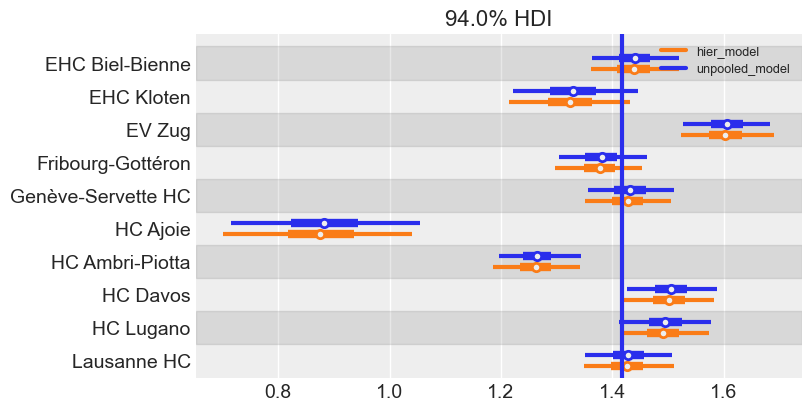

In [30]:
# Convert PyMC3 trace to an arviz InferenceData object (if it's not already)
if not isinstance(trace_unpooled, az.InferenceData):
    trace_unpooled = az.from_pymc3(trace_unpooled)
    trace_hierarchical = az.from_pymc3(trace_hierarchical)


# Plot the forest plot for the first 5 teams only
axes = az.plot_forest([trace_unpooled, trace_hierarchical],
                    model_names = ['unpooled_model', 'hier_model'],
                    var_names=["mu_teams"], 
                    combined=True, 
                    coords={"mu_teams_dim_0": range(10)},  # Only the first 5 teams
                    figsize=(8, 4))

axes[0].set_yticklabels(teams[:10][::-1])

grand_mean = flattened_df["Goals"].mean()
axes[0].axvline(x=grand_mean)

### predictive

In [31]:
with pm.Model() as hierarchical_model:
    
    # Priors for global model parameters
    mu_global = pm.Gamma('mu_global', alpha, beta)
    
    # Rate parameter for Gamma distribution for individual teams
    rate_teams = pm.Exponential('rate_teams', 1/mu_global)
    
    # Individual team means
    mu_teams = pm.Gamma('mu_teams', alpha=mu_global, beta=rate_teams, shape=n_teams)

    # Likelihood for each team's goals
    goals = pm.Poisson('goals', mu=mu_teams[flattened_df['team_code'].values], observed=flattened_df['Goals'])
    
    predictive = pm.Poisson('predictive_hcl', mu=mu_teams[hcl_code])
    
    trace_hierarchical_with_preds = pm.sample(1000, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_teams, rate_teams, mu_global]
>Metropolis: [predictive_hcl]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [32]:
az.summary(trace_hierarchical_with_preds, var_names=['predictive_hcl'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive_hcl,1.506,1.191,0.0,4.0,0.044,0.033,770.0,781.0,1.0


array([[<AxesSubplot: title={'center': 'predictive_hcl'}>,
        <AxesSubplot: title={'center': 'predictive_hcl'}>],
       [<AxesSubplot: title={'center': 'mu_global'}>,
        <AxesSubplot: title={'center': 'mu_global'}>],
       [<AxesSubplot: title={'center': 'rate_teams'}>,
        <AxesSubplot: title={'center': 'rate_teams'}>],
       [<AxesSubplot: title={'center': 'mu_teams'}>,
        <AxesSubplot: title={'center': 'mu_teams'}>]], dtype=object)

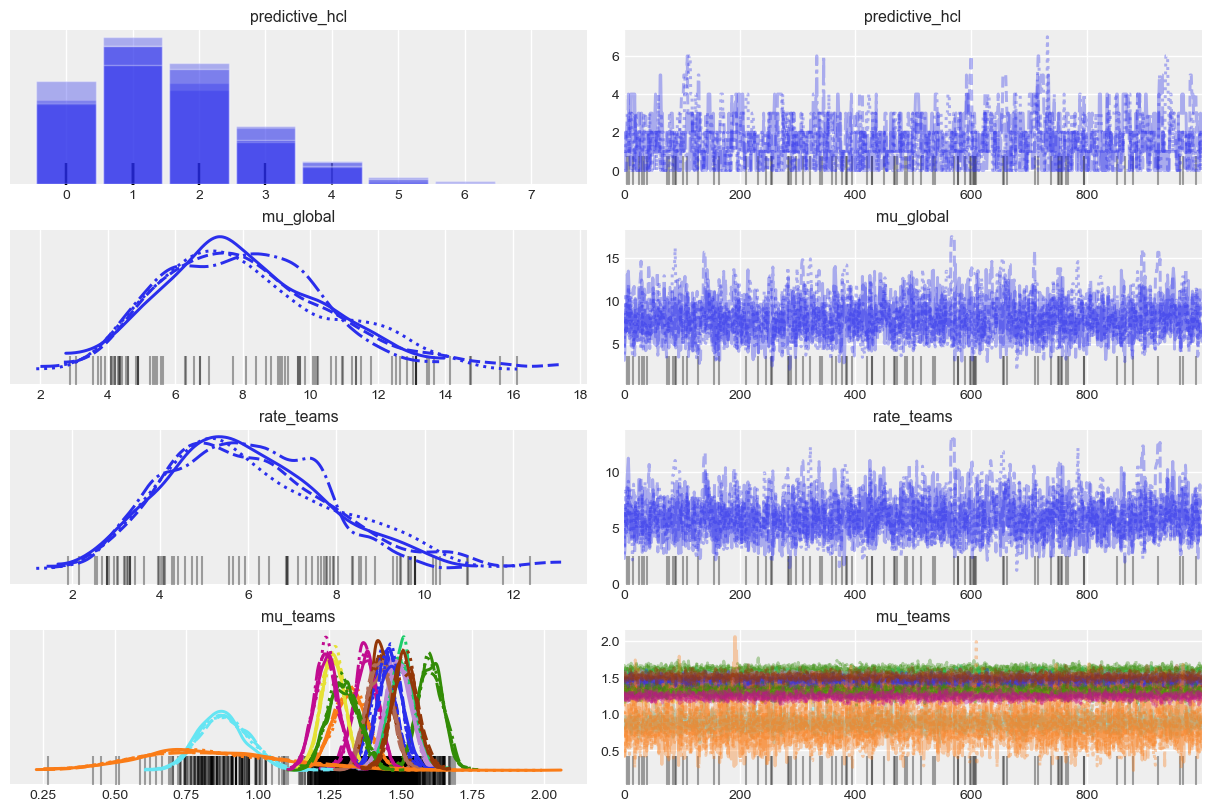

In [33]:
az.plot_trace(trace_hierarchical_with_preds)

# WAIC

In [34]:
pool_waic = az.waic(trace_pooled)
unpool_waic = az.waic(trace_unpooled)
hier_waic = az.waic(trace_hierarchical)

print(pool_waic)
print(unpool_waic)
print(hier_waic)


Computed from 4000 posterior samples and 9800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -19065.70   124.30
p_waic        2.47        -
Computed from 4000 posterior samples and 9800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -19034.85   123.26
p_waic       33.53        -
Computed from 4000 posterior samples and 9800 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -19034.89   123.67
p_waic       33.92        -


In [39]:
comp_df = az.compare({'pooled': trace_pooled, 'unpooled': trace_unpooled,  'hierarchical':trace_hierarchical}, ic='waic')
comp_df

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
unpooled,0,-19034.853920,33.534787,0.000000,0.000000,123.262259,0.000000,False,log
hierarchical,1,-19034.889804,33.923228,0.035884,0.650472,123.673934,0.511389,False,log
pooled,2,-19065.704273,2.469380,30.850352,0.349528,124.300162,14.799945,False,log


<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

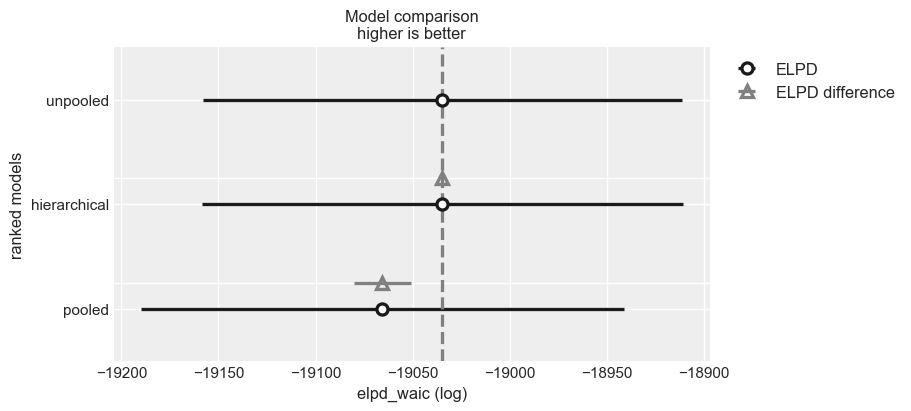

In [38]:
az.plot_compare(comp_df, figsize=(9,4), textsize=11)

The unpooled model is ranked first, vey similar to the hierarchical